# Setup

In [1]:
# !pip install tensorflow

In [2]:
# !pip install transformers
# !pip install datasets
# !pip install scikit-learn

## Check for GPUs

In [3]:
import tensorflow as tf
import pandas as pd

2024-11-30 15:33:01.236947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## Install transformers Library

# Loading CoLA Dataset

In [5]:
from datasets import load_dataset

/home/jaimelicea/miniconda3/envs/p9_bert/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import datasets
import fsspec
import huggingface_hub

print("datasets version:", datasets.__version__)
print("fsspec version:", fsspec.__version__)
print("huggingface_hub version:", huggingface_hub.__version__)


datasets version: 3.1.0
fsspec version: 2024.9.0
huggingface_hub version: 0.26.3


In [7]:
dataset = load_dataset("nbel/EsCoLA")

dataset = dataset.rename_column("Label", "label")
dataset = dataset.rename_column("Sentence", "sentence")

In [8]:
# Visualize
print(dataset["train"][0])
print(dataset['train'].features)

{'ID': 'EsCoLA_5681', 'Source': 'GDE35', 'label': 1, 'Source_annotation': None, 'Annotator_1': 1, 'Annotator_2': 0, 'Annotator_3': 1, 'Human_annotation_median': None, 'sentence': '¿Opinaron si debían hacerlo?', 'Category': 7, 'Split': 'train'}
{'ID': Value(dtype='string', id=None), 'Source': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'Source_annotation': Value(dtype='string', id=None), 'Annotator_1': Value(dtype='int64', id=None), 'Annotator_2': Value(dtype='int64', id=None), 'Annotator_3': Value(dtype='int64', id=None), 'Human_annotation_median': Value(dtype='float64', id=None), 'sentence': Value(dtype='string', id=None), 'Category': Value(dtype='int64', id=None), 'Split': Value(dtype='string', id=None)}


In [9]:
df = pd.DataFrame(dataset['train'])[['sentence', 'label']]
df.head(5)

,sentence,label
0,¿Opinaron si debían hacerlo?,1
1,¿Quién ha llamado?,1
2,No se sabe donde ir.,1
3,"Sólo tenía una peseta, y aquel tipo me pedía d...",0
4,No sabe qué creer.,1


In [10]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

# Tokenization & Preprocessing

1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

In [11]:
# Load the BERT tokenizer.

from transformers import BertTokenizer

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

/home/jaimelicea/miniconda3/envs/p9_bert/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
# Print the original sentence.
print(' Original: ', sentences[0])
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  ¿Opinaron si debían hacerlo?
Tokenized:  ['¿', 'opina', '##ron', 'si', 'debían', 'hacerlo', '?']
Token IDs:  [1067, 19029, 3432, 1112, 10902, 2791, 1064]


In [13]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  ¿Opinaron si debían hacerlo?
Token IDs: [4, 1067, 19029, 3432, 1112, 10902, 2791, 1064, 5]


In [14]:
print('Max length: ', max([len(sen) for sen in input_ids]))

Max length:  60


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

In [16]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:

    # Create the attention mask.
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

# Train and Validation sets split

In [17]:
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=13, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=13, test_size=0.1)

# DataLoader preperation

In [18]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Train Classification model (BertForSequenceClassification)

In [20]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device)

/home/jaimelicea/miniconda3/envs/p9_bert/lib/python3.9/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/jaimelicea/miniconda3/envs/p9_bert/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/jaimelicea/miniconda3/envs/p9_bert/lib/python3.9/site-packages/transformers/modeling_utils.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [22]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Device:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU.")


CUDA is available. Device: NVIDIA GeForce RTX 4060 Laptop GPU


## Optimizer & Learning Rate Scheduler

In [23]:
optimizer = AdamW(model.parameters(), lr = 2e-5,  eps = 1e-8 )

/home/jaimelicea/miniconda3/envs/p9_bert/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training

In [25]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [27]:
import random

seed_val = 13

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()


        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # loss value out of the tuple.
        loss = outputs[0]

        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch


        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    238.    Elapsed: 0:00:11.
  Batch    80  of    238.    Elapsed: 0:00:19.
  Batch   120  of    238.    Elapsed: 0:00:25.
  Batch   160  of    238.    Elapsed: 0:00:33.
  Batch   200  of    238.    Elapsed: 0:00:41.

  Average training loss: 0.54
  Training epcoh took: 0:00:47

Running Validation...
  Accuracy: 0.79
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    238.    Elapsed: 0:00:08.
  Batch    80  of    238.    Elapsed: 0:00:17.
  Batch   120  of    238.    Elapsed: 0:00:25.
  Batch   160  of    238.    Elapsed: 0:00:31.
  Batch   200  of    238.    Elapsed: 0:00:39.

  Average training loss: 0.36
  Training epcoh took: 0:00:47

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    238.    Elapsed: 0:00:08.
  Batch    80  of    238.    Elapsed: 0:00:14.
  Batch   120  of    238.    Elapsed: 0:00:23.
  

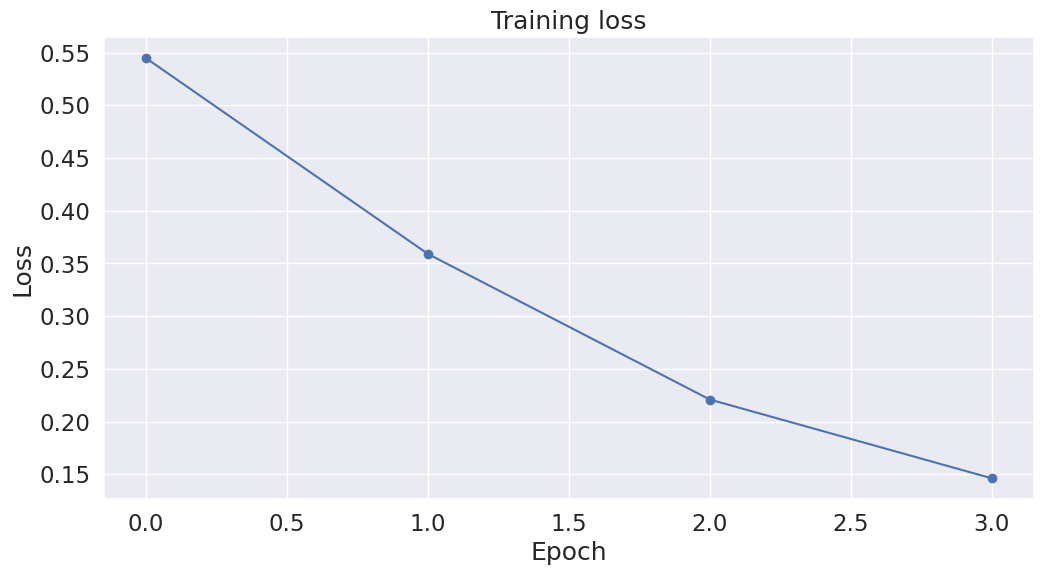

In [29]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show();

# Performance in test Set

Matthew's correlation coefficient is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform this specific task.

In [30]:
df = pd.DataFrame(dataset['validation'])[['sentence', 'label']]
df.head(5)

,sentence,label
0,Ana y Juan son diferentes.,1
1,"Esperando ganar mucho dinero, los empresarios ...",1
2,El médico la ha prohibido fumar.,0
3,María detesta tareas difíciles.,0
4,A nadie le pertenece que juzgue.,0


## Test data preparation

In [31]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []


for sent in sentences:

    encoded_sent = tokenizer.encode(sent, add_special_tokens = True)

    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 1,053



In [32]:
# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)


# Saving the model

In [ ]:
import os

output_dir = './model_esCola/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to ./model_esCola/


('./model_esCola/tokenizer_config.json',
 './model_esCola/special_tokens_map.json',
 './model_esCola/vocab.txt',
 './model_esCola/added_tokens.json')

: 